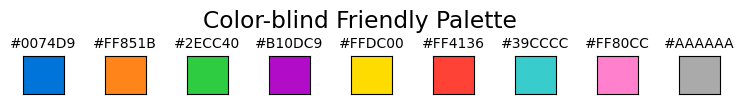

In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'arial' 
plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

from tqdm import tqdm
from dataclasses import dataclass
from pathlib import Path
from scipy.interpolate import interp1d
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axisartist.axislines import AxesZero

HOME = Path.cwd().parent
sys.path.append(str(HOME))

from src.data import BatteryData
from src.builders import MODELS
from src.utils import import_config

pd.options.display.precision = 1
palette = [
    '#0074D9',  # blue
    '#FF851B',  # orange
    '#2ECC40',  # green
    '#B10DC9',  # purple
    '#FFDC00',  # yellow
    '#FF4136',  # red
    '#39CCCC',  # teal
    '#FF80CC',  # pink
    '#AAAAAA',  # gray
]
# Show palette
fig, axes = plt.subplots(1, len(palette), figsize=(len(palette), 0.5))
for color, ax in zip(palette, axes):
    ax.set_facecolor(color)
    ax.set_title(color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Color-blind Friendly Palette', y=1.8)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

Reproduce Figure 1 elements.

In [2]:
path = Path('/workspace/battery/nmi_configs/data/processed/').glob('*/*')
all_batteries = [
    BatteryData.load(p) for p in tqdm(
        list(path), desc='Load cells'
    )
]
material_map = defaultdict(list)
for cell in all_batteries:
    material_map[cell.cathode_material].append(cell)

Load cells: 100%|██████████| 403/403 [02:56<00:00,  2.28it/s]


In [3]:
# Helper functions
def get_V_of_Qd(cycle_data, C, interp_dims=1000, mode='discharge', xe=1.):
    I = np.array(cycle_data.current_in_A)  # noqa
    V = np.array(cycle_data.voltage_in_V)
    Qc = np.array(cycle_data.charge_capacity_in_Ah) / C
    Qd = np.array(cycle_data.discharge_capacity_in_Ah) / C

    charge_mask, discharge_mask = I > 0.1, I < -0.1
    Qc, Qd = Qc[charge_mask], Qd[discharge_mask]
    Ic, Id = I[charge_mask], I[discharge_mask]
    Vc, Vd = V[charge_mask], V[discharge_mask]
    # V(Qc), V(Qd), I(Qc), I(Qd)
    res = interpolate( Qd, Vd, interp_dims, mode, 0., xe)
    return res

def get_features(cycle_data, C, interp_dims=1000, xe=1.):
    I = np.array(cycle_data.current_in_A)  # noqa
    V = np.array(cycle_data.voltage_in_V)
    Qc = np.array(cycle_data.charge_capacity_in_Ah) / C
    Qd = np.array(cycle_data.discharge_capacity_in_Ah) / C

    charge_mask, discharge_mask = I > 0.1, I < -0.1
    Qc, Qd = Qc[charge_mask], Qd[discharge_mask]
    Ic, Id = I[charge_mask], I[discharge_mask]
    Vc, Vd = V[charge_mask], V[discharge_mask]
    # V(Qc), V(Qd), I(Qc), I(Qd)
    cycle_feature = [
        interpolate(
            Qc, Vc, interp_dims, 'charge', xe=xe),
        interpolate(
            Qd, Vd, interp_dims, 'discharge', xe=xe),
        interpolate(Qc, Ic, interp_dims, xe=xe),
        interpolate(Qd, Id, interp_dims, xe=xe),
    ]
    # delta_V(Q)
    cycle_feature.append(
        cycle_feature[0] - cycle_feature[1][::-1]
    )
    # R(Q)
    cycle_feature.append(
        (cycle_feature[0] - cycle_feature[1][::-1])
        / (cycle_feature[2] - cycle_feature[3][::-1] + 1e-3)
    )
    return np.stack(cycle_feature)

def interpolate(x, y, interp_dims, fill_type='', xs=0, xe=1.):
    if len(x) <= 2:
        return np.zeros(interp_dims)
    mask = (x >= xs) & (x <= xe)
    x, y = x[mask], y[mask]
    if fill_type == 'charge':
        fill_values = (y.min(), y.max())
    elif fill_type == 'discharge':
        fill_values = (y.max(), y.min())
    else:
        fill_values = float('nan')
    func = interp1d(
        x, y,
        kind='linear',
        bounds_error=False,
        fill_value=fill_values)
    return func(np.linspace(xs, xe, interp_dims))

def get_cycle_life(cell_data, ths=0.8):
    ths = cell_data.nominal_capacity_in_Ah * ths
    for i in range(len(cell_data.cycle_data)):
        if max(cell_data.cycle_data[i].discharge_capacity_in_Ah) <= ths:
            break
    return i

In [19]:
def get_datasource(cell: BatteryData):
    datasource, cell_id = cell.cell_id.split('_', 1)

    if datasource == 'MATR':
        indx = int(cell_id[1]) - 1
        datasource += matr_batch_names[indx]

    elif datasource == 'SNL':
        mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
        if mean_temp < 20:
            datasource = 'SNL-temp-18C'
        elif mean_temp < 30:
            datasource = 'SNL-temp-26C'
        else:
            datasource = 'SNL-temp-36C'

    return datasource

matr_batch_names = ['-2017-05', '-2017-06', '-2018-04', '-2019-01']
markers = iter(['o', '*', 'd', 's', 'P', '1', 'x', (6, 2, 0)])

ds_to_marker = {}
for cell in material_map['LFP']:
    datasource = get_datasource(cell)
    if datasource not in ds_to_marker:
        ds_to_marker[datasource] = next(markers)

ds_to_marker

/tmp/ipykernel_4170999/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)


{'MATR-2017-05': 'o',
 'MATR-2017-06': '*',
 'MATR-2018-04': 'd',
 'MATR-2019-01': 's',
 'HUST': 'P',
 'SNL-temp-26C': '1',
 'SNL-temp-36C': 'x',
 'SNL-temp-18C': (6, 2, 0)}

Process LFP cells:   0%|          | 0/275 [00:00<?, ?it/s]

Process LFP cells:  95%|█████████▍| 260/275 [00:03<00:00, 64.11it/s] /tmp/ipykernel_4170999/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 72.95it/s]


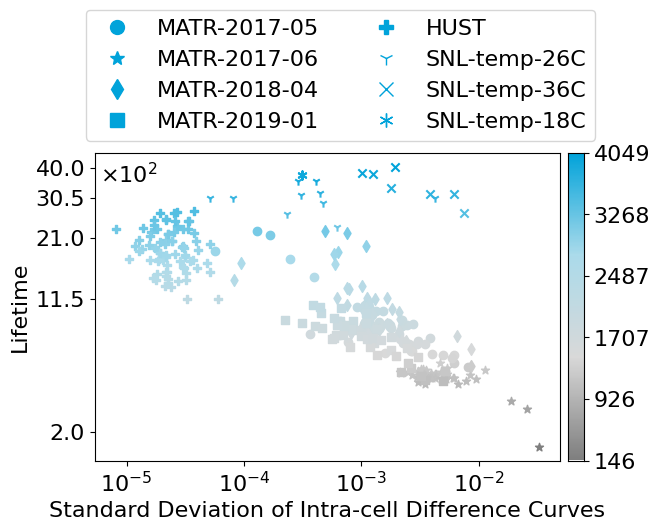

In [20]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#7F7F7F', '#D9D9D9', '#ABDBEB', '#00A3DA'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels, markers = [], [], []
for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    q10 = get_V_of_Qd(cell.cycle_data[9], cell.nominal_capacity_in_Ah)
    q100 = get_V_of_Qd(cell.cycle_data[99], cell.nominal_capacity_in_Ah)
    var = np.var(q100 - q10)
    label = get_cycle_life(cell)
    vars_.append(np.log10(var))
    labels.append(label)
    markers.append(ds_to_marker[get_datasource(cell)])
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
yticks = np.linspace(200, 4000, 5)
yticks = np.log10(yticks - min_labels + 400)
gap = labels.max() - labels.min()
for var, label, marker in zip(vars_, labels, markers):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap), marker=marker)
ax.set_yticks(yticks, labels=[round(10**y-400+min_labels)/100 for y in yticks])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')

xticks = [-2, -3, -4, -5]
ax.set_xticks(xticks, [f'$10^{{{x}}}$' for x in xticks])

handles = []
labels = []
for category, marker in ds_to_marker.items():
    handle = plt.Line2D(
        [0], [0],
        marker=marker,
        linestyle='none',
        markeredgecolor=colors[-1],
        markerfacecolor=colors[-1],
        markersize=10
    )
    handles.append(handle)
    labels.append(category)

# Add the legend
ax.legend(handles, labels, bbox_to_anchor=(1.1, 1.5), ncols=2)
ax.set_ylabel('Lifetime')
ax.set_xlabel('Standard Deviation of Intra-cell Difference Curves')

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
# fig.savefig(
#     HOME / f'data/stats_self_diff_square.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Process LFP cells:   0%|          | 0/275 [00:00<?, ?it/s]

Process LFP cells:  95%|█████████▍| 260/275 [00:03<00:00, 55.04it/s]/tmp/ipykernel_4170999/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 72.67it/s]


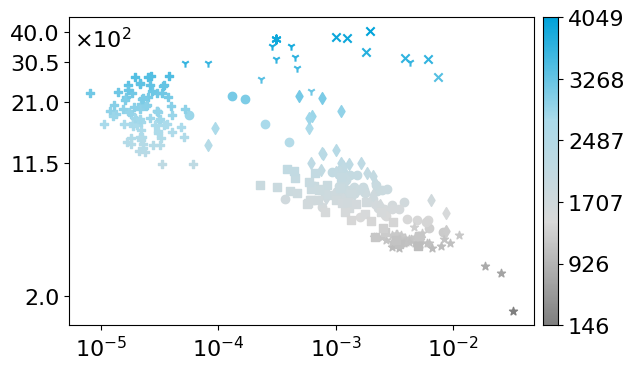

In [21]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#7F7F7F', '#D9D9D9', '#ABDBEB', '#00A3DA'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels, markers = [], [], []
for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    q10 = get_V_of_Qd(cell.cycle_data[9], cell.nominal_capacity_in_Ah)
    q100 = get_V_of_Qd(cell.cycle_data[99], cell.nominal_capacity_in_Ah)
    var = np.var(q100 - q10)
    label = get_cycle_life(cell)
    vars_.append(np.log10(var))
    labels.append(label)
    markers.append(ds_to_marker[get_datasource(cell)])
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
yticks = np.linspace(200, 4000, 5)
yticks = np.log10(yticks - min_labels + 400)
gap = labels.max() - labels.min()
for var, label, marker in zip(vars_, labels, markers):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap), marker=marker)
ax.set_yticks(yticks, labels=[round(10**y-400+min_labels)/100 for y in yticks])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')

xticks = [-2, -3, -4, -5]
ax.set_xticks(xticks, [f'$10^{{{x}}}$' for x in xticks])

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
fig.savefig(
    HOME / f'data/stats_self_diff_square.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Process LFP cells:   0%|          | 0/275 [00:00<?, ?it/s]

Process LFP cells:  95%|█████████▍| 260/275 [00:03<00:00, 62.13it/s] /tmp/ipykernel_4170999/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 78.51it/s]


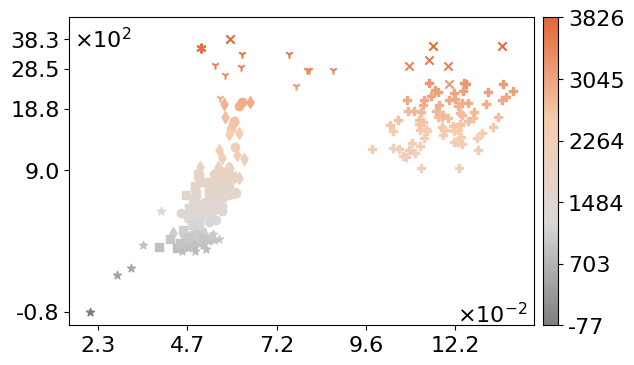

In [22]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#7F7F7F', '#D9D9D9', '#F7CCAE', '#E26837'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

cycle = 99
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels, markers = [], [], []

base_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    label_diff = get_cycle_life(cell) - base_label
    q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
    feat = (q100 - base_100)
    # signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
    signed_var = np.log10(np.var(feat) + 1)
    vars_.append(signed_var)
    labels.append(label_diff)
    markers.append(ds_to_marker[get_datasource(cell)])
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
gap = labels.max() - labels.min()
for var, label, marker in zip(vars_, labels, markers):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap), marker=marker)
yticks = np.linspace(min_labels, max_labels, 5)
yticks = np.log10(yticks - min_labels + 400)
ytick_labels = [round(10**y-400+min_labels)/100 for y in yticks]
ax.set_yticks(yticks, labels=[f'{y:.1f}' for y in ytick_labels])
ax.set_ylim([ax.get_ylim()[0], labels.max() * 1.023])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')
# xticks = [-0.05, -0.04, -0.03, -0.02, -0.01]
xticks = np.arange(0.01, 0.06, 0.01)
xtick_labels = [10**x-1 for x in xticks]
ax.set_xticks(xticks, labels=[f'{x*100:.1f}'for x in xtick_labels])
x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 6
y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
fig.savefig(HOME / f'data/stats_cross_diff_diff_mat_square.svg',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

Process LFP cells:   0%|          | 0/275 [00:00<?, ?it/s]

Process LFP cells:  95%|█████████▌| 262/275 [00:03<00:00, 70.03it/s] /tmp/ipykernel_4170999/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 81.17it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


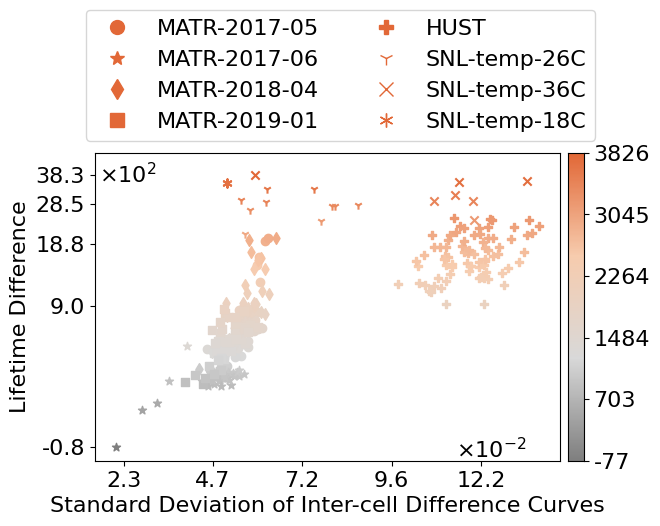

In [23]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#7F7F7F', '#D9D9D9', '#F7CCAE', '#E26837'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

cycle = 99
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels, markers = [], [], []

base_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    label_diff = get_cycle_life(cell) - base_label
    q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
    feat = (q100 - base_100)
    # signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
    signed_var = np.log10(np.var(feat) + 1)
    vars_.append(signed_var)
    labels.append(label_diff)
    markers.append(ds_to_marker[get_datasource(cell)])
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
gap = labels.max() - labels.min()
for var, label, marker in zip(vars_, labels, markers):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap), marker=marker)
yticks = np.linspace(min_labels, max_labels, 5)
yticks = np.log10(yticks - min_labels + 400)
ytick_labels = [round(10**y-400+min_labels)/100 for y in yticks]
ax.set_yticks(yticks, labels=[f'{y:.1f}' for y in ytick_labels])
ax.set_ylim([ax.get_ylim()[0], labels.max() * 1.023])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')
xticks = np.arange(0.01, 0.06, 0.01)
xtick_labels = [10**x-1 for x in xticks]
ax.set_xticks(xticks, labels=[f'{x*100:.1f}'for x in xtick_labels])
x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 4.5
y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

handles = []
labels = []
for category, marker in ds_to_marker.items():
    handle = plt.Line2D(
        [0], [0],
        marker=marker,
        linestyle='none',
        markeredgecolor=colors[-1],
        markerfacecolor=colors[-1],
        markersize=10
    )
    handles.append(handle)
    labels.append(category)

# Add the legend
ax.legend(handles, labels, bbox_to_anchor=(1.1, 1.5), ncols=2)
ax.set_ylabel('Lifetime Difference')
ax.set_xlabel('Standard Deviation of Inter-cell Difference Curves')

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
plt.show()

Processing LFP cells:   0%|          | 0/275 [00:00<?, ?it/s]

Processing NCA cells: 100%|██████████| 22/22 [00:00<00:00, 507.24it/s]


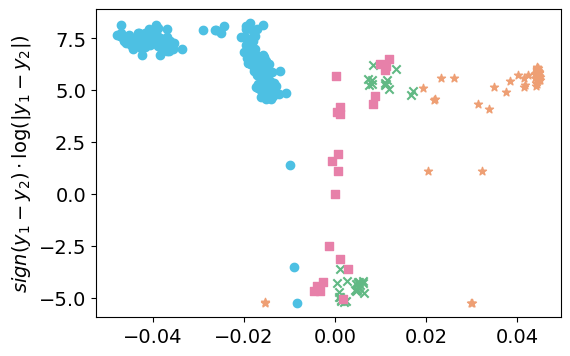

In [5]:
cycle = 99
colors = iter(['#4DC0E3', '#EE9F74', '#61B984', '#E780A9'])
markers = iter(['o', '*', 'x', 's', 'd', '1'])

# Figure object
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16

base_cell = list(sorted(
    material_map['NCA'], key=lambda x: x.cell_id
))[0]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

for material, material_cells in material_map.items():
    vars_, labels = [], []
    for cell in tqdm(material_cells, desc=f'Processing {material} cells'):
        label_diff = get_cycle_life(cell) - base_label
        q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
        feat = (q100 - base_100)
        signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
        vars_.append(signed_var)
        labels.append(label_diff)
    color, marker = next(colors), next(markers)
    max_labels, min_labels = max(labels), min(labels)
    # labels = np.array(labels) - np.mean(labels)
    signed_log_labels = np.log(np.abs(labels) + 1) * np.sign(labels)
    ax.scatter(vars_, signed_log_labels, color=color, marker=marker)
ax.set_ylabel(r'$sign(y_1-y_2)\cdot\log(|y_1-y_2|)$')

plt.show()

Processing LFP cells:   0%|          | 0/275 [00:00<?, ?it/s]

Processing NCA cells: 100%|██████████| 22/22 [00:00<00:00, 564.32it/s]


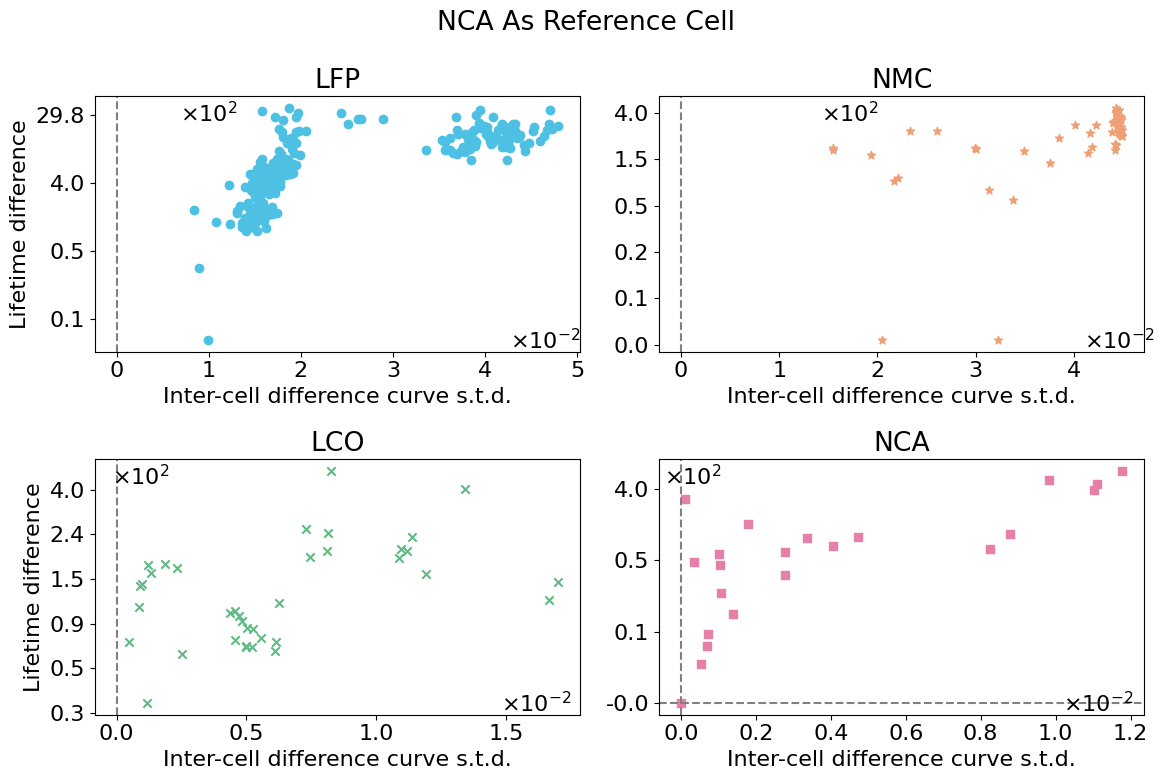

In [7]:
# Start plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.rcParams['font.size'] = 16

base_material = 'NCA'
base_cell = list(sorted(
    material_map[base_material], key=lambda x: x.cell_id
))[0]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

# Serialized
colors = iter(['#4DC0E3', '#EE9F74', '#61B984', '#E780A9'])
markers = iter(['o', '*', 'x', 's', 'd', '1'])
axes_iter = iter(axes.reshape(-1))

for material, material_cells in material_map.items():
    ax = next(axes_iter)
    vars_, labels = [], []
    for cell in tqdm(material_cells, desc=f'Processing {material} cells'):
        label_diff = get_cycle_life(cell) - base_label
        q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
        feat = (q100 - base_100)
        # signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
        signed_var = np.log10(np.var(feat) + 1)
        label_diff = abs(label_diff)
        vars_.append(signed_var)
        labels.append(label_diff)
    color, marker = next(colors), next(markers)
    max_labels, min_labels = max(labels), min(labels)
    signed_log_labels = np.log(np.abs(labels) + 1) * np.sign(labels)
    ax.scatter(np.array(vars_) * 100, signed_log_labels, color=color, marker=marker)
    ax.set_title(material)
    x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
    y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
    ax.text(x_pos, y_pos, '$\\times 10^2$')
    x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 6
    y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
    ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

    # yticks
    ylim = ax.get_ylim()
    yticks = ax.get_yticks()
    ytick_labels = (np.exp(abs(yticks)) * np.sign(yticks) - 1) / 100
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{x:.1f}' for x in ytick_labels])
    ax.set_ylim(ylim)
    # ax.set_ylabel(r'$sign(y_1-y_2)\cdot\log(|y_1-y_2|)$')

    ax.vlines([0], *ax.get_ylim(), color='grey', linestyles='--')
    xlim = ax.get_xlim()
    ax.hlines([0], *ax.get_xlim(), color='grey', linestyles='--')
    ax.set_xlim(xlim)
    ax.set_xlabel('Inter-cell difference curve s.t.d.')
    

axes[0, 0].set_ylabel('Lifetime difference')
axes[1, 0].set_ylabel('Lifetime difference')
fig.suptitle(f'{base_material} As Reference Cell')
plt.tight_layout()
plt.show()

Processing NCA cells: 100%|██████████| 22/22 [00:00<00:00, 543.12it/s]


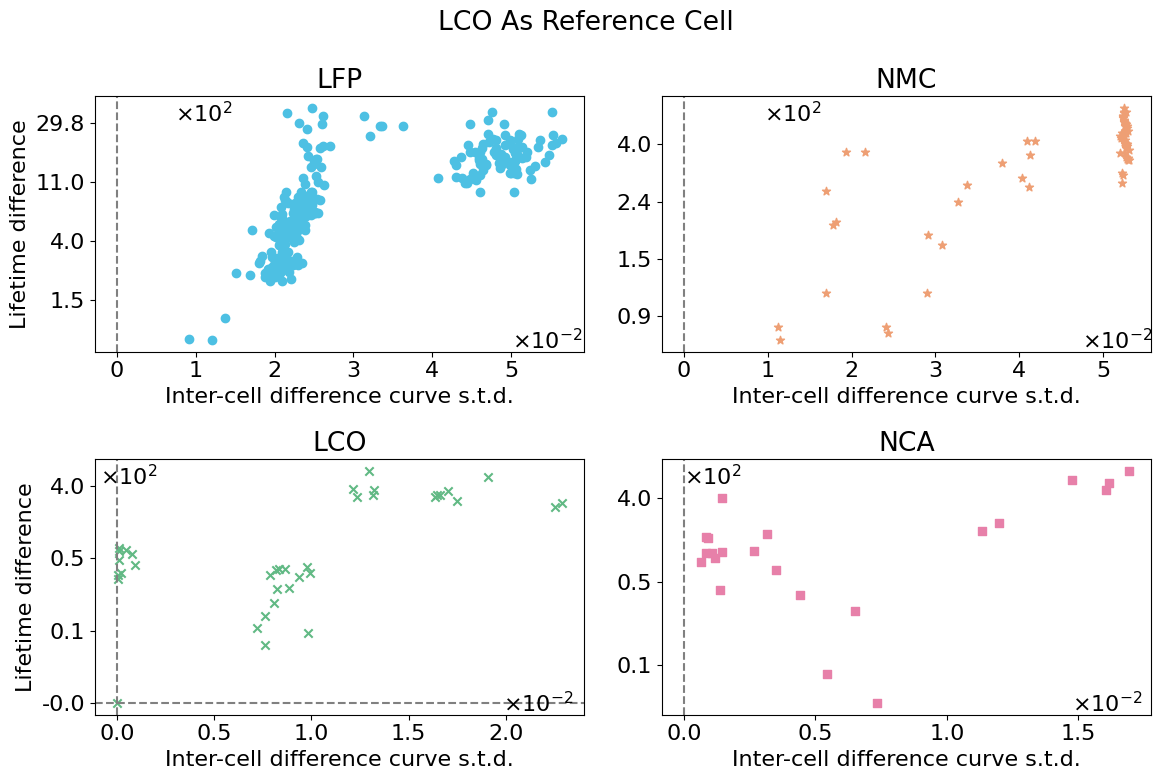

In [8]:
# Start plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.rcParams['font.size'] = 16

base_material = 'LCO'
base_cell = list(sorted(
    material_map[base_material], key=lambda x: x.cell_id
))[-7]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

# Serialized
colors = iter(['#4DC0E3', '#EE9F74', '#61B984', '#E780A9'])
markers = iter(['o', '*', 'x', 's', 'd', '1'])
axes_iter = iter(axes.reshape(-1))

for material, material_cells in material_map.items():
    ax = next(axes_iter)
    vars_, labels = [], []
    for cell in tqdm(material_cells, desc=f'Processing {material} cells'):
        label_diff = get_cycle_life(cell) - base_label
        q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
        feat = (q100 - base_100)
        # signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
        signed_var = np.log10(np.var(feat) + 1)
        label_diff = abs(label_diff)
        vars_.append(signed_var)
        labels.append(label_diff)
    color, marker = next(colors), next(markers)
    max_labels, min_labels = max(labels), min(labels)
    signed_log_labels = np.log(np.abs(labels) + 1) * np.sign(labels)
    ax.scatter(np.array(vars_) * 100, signed_log_labels, color=color, marker=marker)
    ax.set_title(material)
    x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
    y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
    ax.text(x_pos, y_pos, '$\\times 10^2$')
    x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 6
    y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
    ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

    # yticks
    ylim = ax.get_ylim()
    yticks = ax.get_yticks()
    ytick_labels = (np.exp(abs(yticks)) * np.sign(yticks) - 1) / 100
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{x:.1f}' for x in ytick_labels])
    ax.set_ylim(ylim)
    # ax.set_ylabel(r'$sign(y_1-y_2)\cdot\log(|y_1-y_2|)$')

    ax.vlines([0], *ax.get_ylim(), color='grey', linestyles='--')
    xlim = ax.get_xlim()
    ax.hlines([0], *ax.get_xlim(), color='grey', linestyles='--')
    ax.set_xlim(xlim)
    
    ax.set_xlabel('Inter-cell difference curve s.t.d.')
    

axes[0, 0].set_ylabel('Lifetime difference')
axes[1, 0].set_ylabel('Lifetime difference')
fig.suptitle(f'{base_material} As Reference Cell')
plt.tight_layout()
plt.show()

Processing NCA cells: 100%|██████████| 22/22 [00:00<00:00, 487.16it/s]


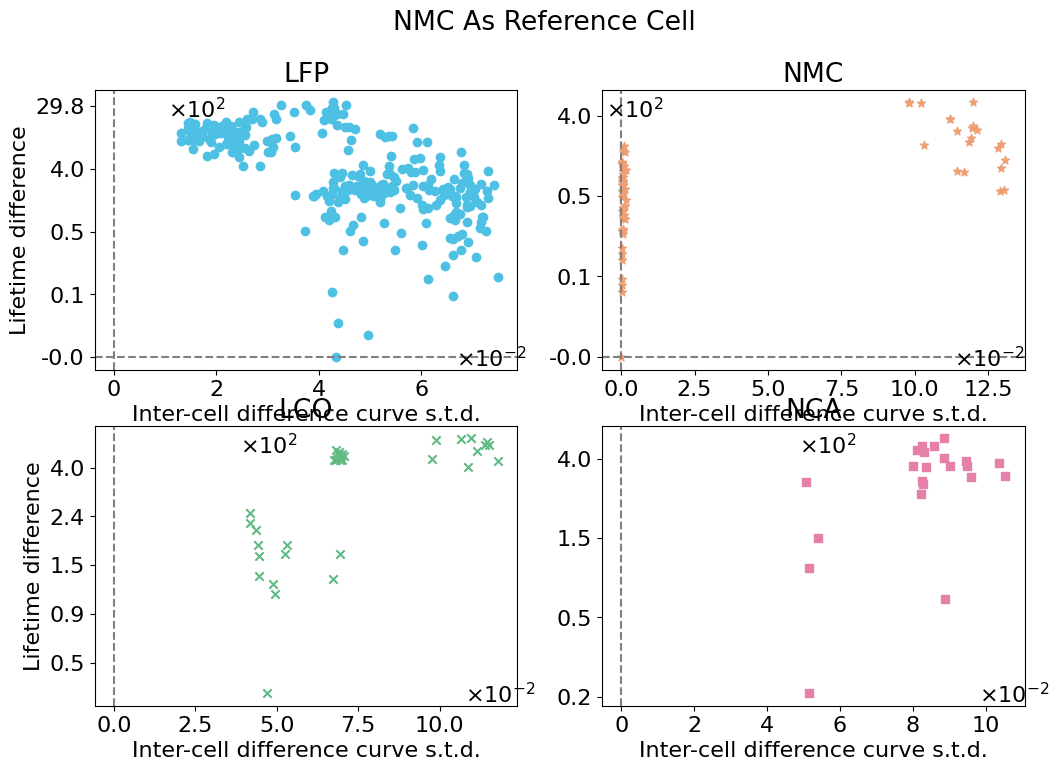

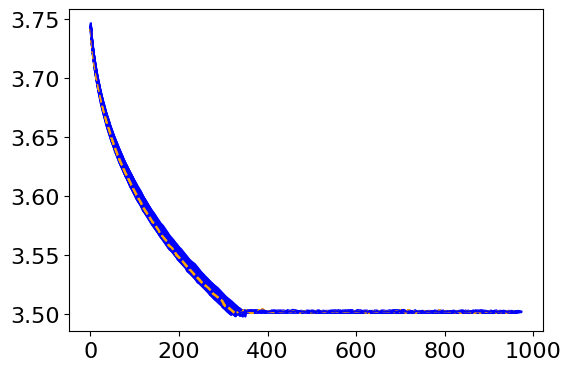

In [40]:
cycle = 0
# Start plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.rcParams['font.size'] = 16

temp_fig, temp_ax = plt.subplots(1, 1, figsize=(6, 4))
not_plot = True

base_material = 'NMC'
base_cell = list(sorted(
    material_map[base_material], key=lambda x: x.cell_id
))[11]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah, mode='nan')
base_label = get_cycle_life(base_cell)

# Serialized
colors = iter(['#4DC0E3', '#EE9F74', '#61B984', '#E780A9'])
markers = iter(['o', '*', 'x', 's', 'd', '1'])
axes_iter = iter(axes.reshape(-1))

for material, material_cells in material_map.items():
    ax = next(axes_iter)
    vars_, labels = [], []
    for cell in tqdm(material_cells, desc=f'Processing {material} cells'):
        label_diff = get_cycle_life(cell) - base_label
        q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah, mode='nan')
        feat = (q100 - base_100)
        # signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
        # signed_var = np.log10(np.var(feat) + 1)
        signed_var = np.log10(np.nanstd(feat) + 1)
        label_diff = abs(label_diff)
        vars_.append(signed_var)
        labels.append(label_diff)
        if signed_var < 1e-2 and not_plot:
            temp_ax.plot(base_100, color='orange', linestyle='--')
            temp_ax.plot(q100, color='blue')

    color, marker = next(colors), next(markers)
    max_labels, min_labels = max(labels), min(labels)
    signed_log_labels = np.log(np.abs(labels) + 1) * np.sign(labels)
    ax.scatter(np.array(vars_) * 100, signed_log_labels, color=color, marker=marker)
    ax.set_title(material)
    x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
    y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
    ax.text(x_pos, y_pos, '$\\times 10^2$')
    x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 6
    y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
    ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

    # yticks
    ylim = ax.get_ylim()
    yticks = ax.get_yticks()
    ytick_labels = (np.exp(abs(yticks)) * np.sign(yticks) - 1) / 100
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{x:.1f}' for x in ytick_labels])
    ax.set_ylim(ylim)
    # ax.set_ylabel(r'$sign(y_1-y_2)\cdot\log(|y_1-y_2|)$')

    ax.vlines([0], *ax.get_ylim(), color='grey', linestyles='--')
    xlim = ax.get_xlim()
    ax.hlines([0], *ax.get_xlim(), color='grey', linestyles='--')
    ax.set_xlim(xlim)
    ax.set_xlabel('Inter-cell difference curve s.t.d.')
    

axes[0, 0].set_ylabel('Lifetime difference')
axes[1, 0].set_ylabel('Lifetime difference')
    
fig.suptitle(f'{base_material} As Reference Cell')
plt.tight_layout()
plt.show()

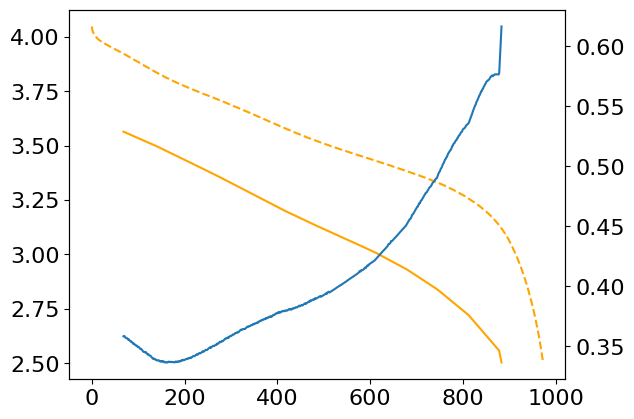

In [28]:
plt.plot(
    get_V_of_Qd(cell.cycle_data[0], cell.nominal_capacity_in_Ah, mode='nan'), color='orange', linestyle='--'
)
plt.plot(
    get_V_of_Qd(cell.cycle_data[100], cell.nominal_capacity_in_Ah, mode='nan'), color='orange'
)
plt.twinx()
plt.plot(
    get_V_of_Qd(cell.cycle_data[0], cell.nominal_capacity_in_Ah, mode='nan')
    - get_V_of_Qd(cell.cycle_data[100], cell.nominal_capacity_in_Ah, mode='nan')
)
plt.show()

Processing NCA cells: 100%|██████████| 22/22 [00:00<00:00, 507.03it/s]


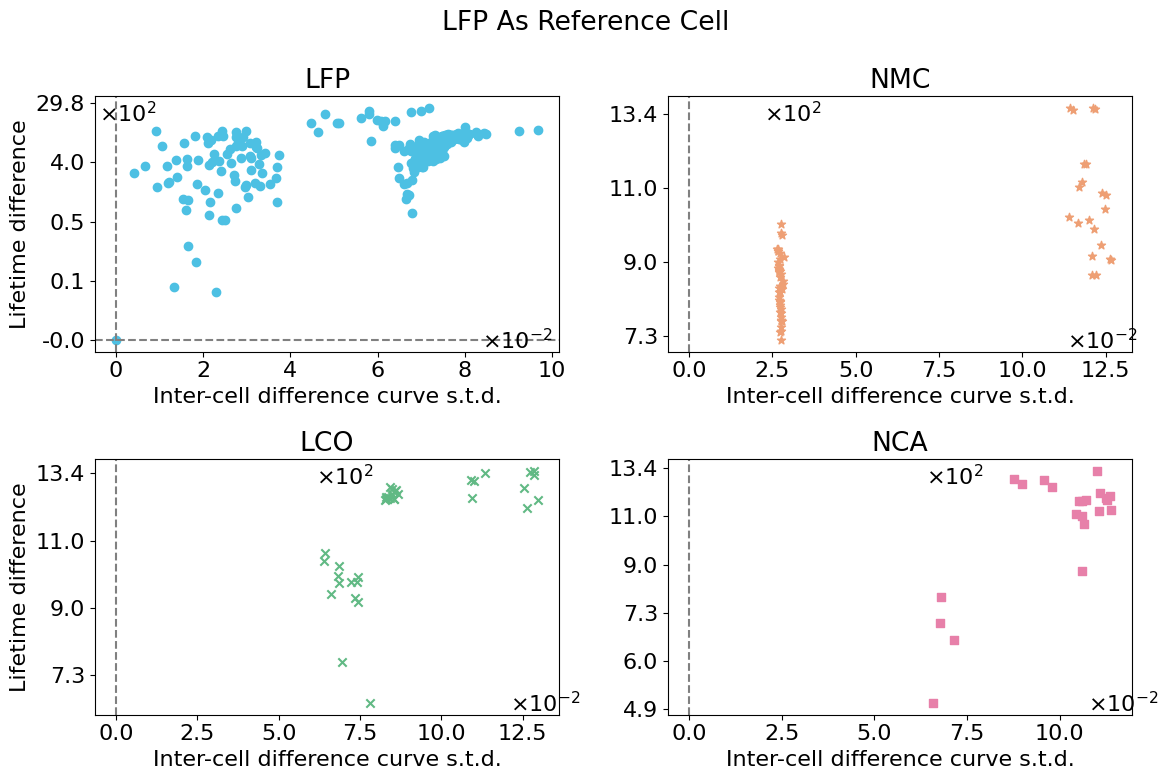

In [29]:
# Start plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.rcParams['font.size'] = 16

base_material = 'LFP'
base_cell = list(sorted(
    material_map[base_material], key=lambda x: x.cell_id
))[0]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah, mode='nan')
base_label = get_cycle_life(base_cell)

# Serialized
colors = iter(['#4DC0E3', '#EE9F74', '#61B984', '#E780A9'])
markers = iter(['o', '*', 'x', 's', 'd', '1'])
axes_iter = iter(axes.reshape(-1))

for material, material_cells in material_map.items():
    ax = next(axes_iter)
    vars_, labels = [], []
    for cell in tqdm(material_cells, desc=f'Processing {material} cells'):
        label_diff = get_cycle_life(cell) - base_label
        q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah, mode='nan')
        feat = (q100 - base_100)
        # signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
        signed_var = np.log10(np.nanstd(feat) + 1)
        label_diff = abs(label_diff)
        vars_.append(signed_var)
        labels.append(label_diff)
    color, marker = next(colors), next(markers)
    max_labels, min_labels = max(labels), min(labels)
    signed_log_labels = np.log(np.abs(labels) + 1) * np.sign(labels)
    ax.scatter(np.array(vars_) * 100, signed_log_labels, color=color, marker=marker)
    ax.set_title(material)
    x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
    y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
    ax.text(x_pos, y_pos, '$\\times 10^2$')
    x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 6
    y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
    ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

    # yticks
    ylim = ax.get_ylim()
    yticks = ax.get_yticks()
    ytick_labels = (np.exp(abs(yticks)) * np.sign(yticks) - 1) / 100
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{x:.1f}' for x in ytick_labels])
    ax.set_ylim(ylim)
    # ax.set_ylabel(r'$sign(y_1-y_2)\cdot\log(|y_1-y_2|)$')

    ax.vlines([0], *ax.get_ylim(), color='grey', linestyles='--')
    xlim = ax.get_xlim()
    ax.hlines([0], *ax.get_xlim(), color='grey', linestyles='--')
    ax.set_xlim(xlim)
    ax.set_xlabel('Inter-cell difference curve s.t.d.')
    

axes[0, 0].set_ylabel('Lifetime difference')
axes[1, 0].set_ylabel('Lifetime difference')
    
fig.suptitle(f'{base_material} As Reference Cell')
plt.tight_layout()
plt.show()

In [25]:
from itertools import chain

cycle = 99

for cell in tqdm(
    chain(*material_map.values()),
    desc='Calculating features and labels',
    total=sum(len(x) for x in material_map.values())
):
    feat = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
    label = get_cycle_life(cell)
    cell.feature, cell.label = feat, label

Calculating features and labels: 100%|██████████| 403/403 [00:04<00:00, 93.69it/s] 


Drawing all figures:   0%|          | 0/16 [00:00<?, ?it/s]

Drawing all figures:   6%|▋         | 1/16 [00:05<01:16,  5.13s/it]

LFP LFP 47 61


Drawing all figures:  12%|█▎        | 2/16 [00:06<00:40,  2.88s/it]

LFP NMC 51 57


Drawing all figures:  19%|█▉        | 3/16 [00:07<00:24,  1.89s/it]

LFP LCO 22 0


Drawing all figures:  25%|██▌       | 4/16 [00:07<00:15,  1.32s/it]

LFP NCA 7 8


Drawing all figures:  31%|███▏      | 5/16 [00:08<00:14,  1.31s/it]

NMC LFP 259 171


Drawing all figures:  38%|███▊      | 6/16 [00:09<00:09,  1.02it/s]

NMC NMC 68 63


Drawing all figures:  44%|████▍     | 7/16 [00:09<00:06,  1.39it/s]

NMC LCO 21 11


Drawing all figures:  50%|█████     | 8/16 [00:09<00:04,  1.89it/s]

NMC NCA 15 11


Drawing all figures:  56%|█████▋    | 9/16 [00:10<00:04,  1.72it/s]

LCO LFP 266 77


Drawing all figures:  62%|██████▎   | 10/16 [00:10<00:02,  2.18it/s]

LCO NMC 68 38


Drawing all figures:  69%|██████▉   | 11/16 [00:10<00:01,  2.84it/s]

LCO LCO 1 21


LCO NCA 1 12


Drawing all figures:  81%|████████▏ | 13/16 [00:11<00:00,  3.29it/s]

NCA LFP 263 49


Drawing all figures:  88%|████████▊ | 14/16 [00:11<00:00,  3.86it/s]

NCA NMC 65 62


NCA LCO 4 27


Drawing all figures: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


NCA NCA 3 4


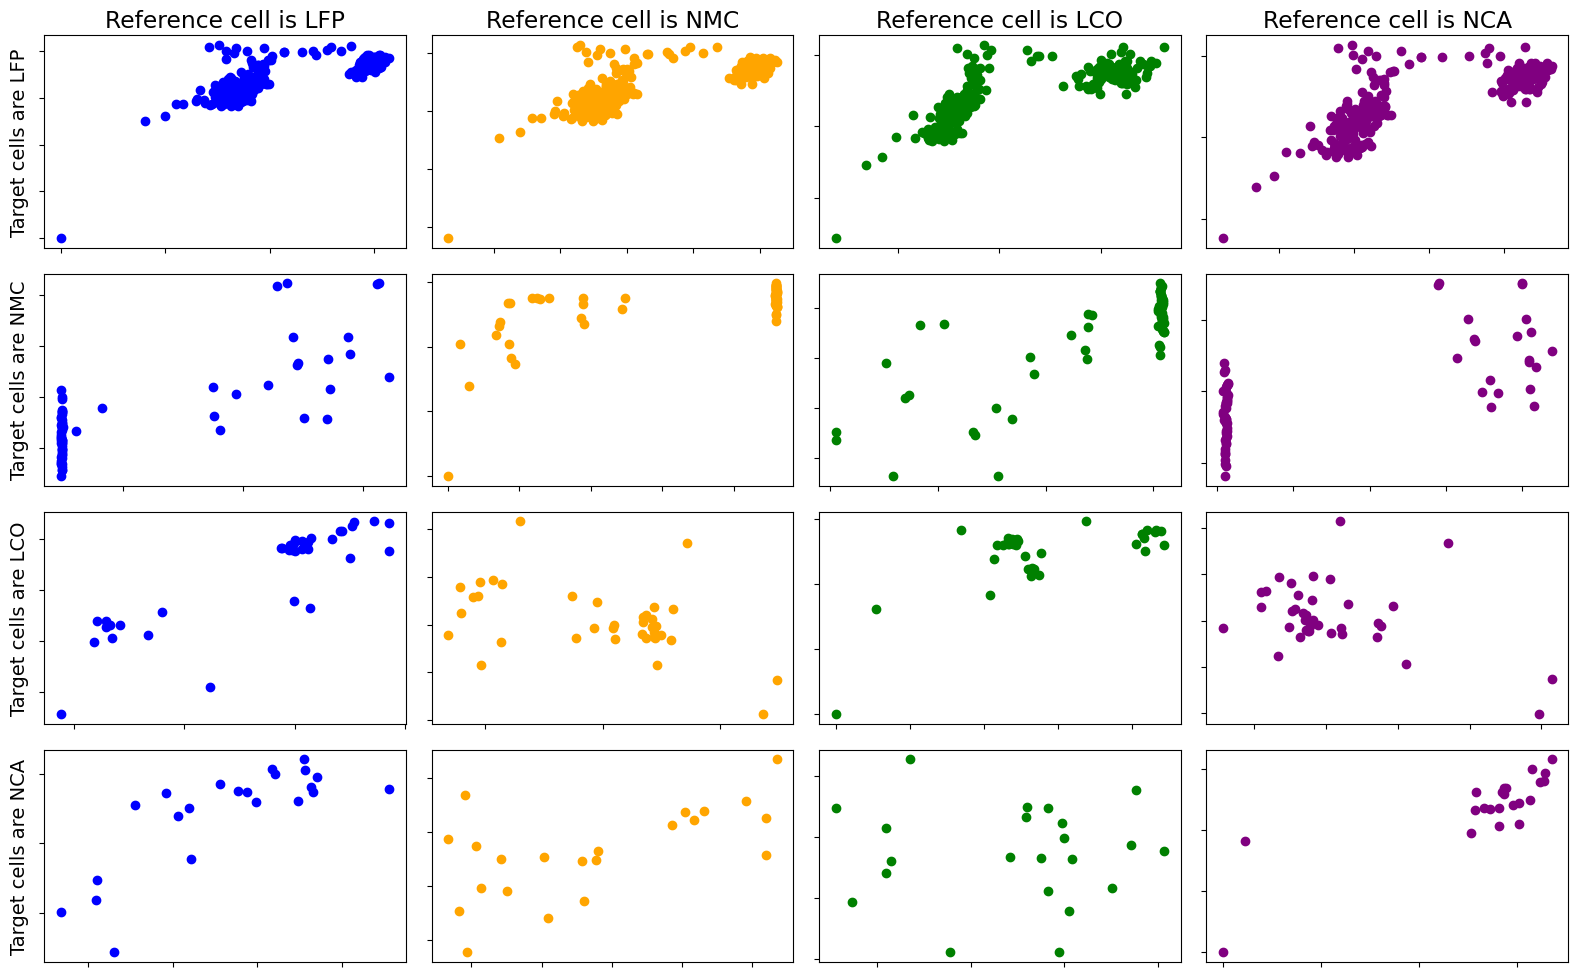

In [6]:
from itertools import product

def least_squares_loss(x, y):
    if len(x) != len(y):
        raise ValueError("The length of x and y must be the same.")
    
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator = sum((xi - mean_x) ** 2 for xi in x)
    
    if denominator == 0:
        raise ValueError("Variance of x is zero, cannot fit a linear model.")
    
    b = numerator / denominator
    a = mean_y - b * mean_x
    
    loss = sum((yi - (a + b * xi)) ** 2 for xi, yi in zip(x, y))
    
    return loss

def get_x(feat_a, feat_b):
    return np.log(np.nanstd(feat_a - feat_b) + 1)

materials = list(material_map.keys())
colors = ['blue', 'orange', 'green', 'purple']
fig, axes = plt.subplots(len(materials), len(materials), figsize=(16, 10))

for i, j in tqdm(
    product(range(len(materials)), range(len(materials))),
    desc='Drawing all figures',
    total=len(materials) ** 2
):
    mat, ref_mat, ax, color = materials[i], materials[j], axes[i][j], colors[j]
    mat_features = [cell.feature for cell in material_map[mat]]
    mat_labels = [cell.label for cell in material_map[mat]]
    # Pick the cell with the lowest error
    errors = []
    for ref_cell in tqdm(material_map[ref_mat], leave=False, desc=f'Calc {mat}-{ref_mat}'):
        x = [get_x(ref_cell.feature, f) for f in mat_features]
        y = [np.log(abs(ref_cell.label - l) + 1) for l in mat_labels]
        errors.append(least_squares_loss(x, y))

    print(mat, ref_mat, np.argmin(errors), np.argmax(errors))

    ref_cell = material_map[ref_mat][np.argmin(errors)]
    x = [get_x(ref_cell.feature, f) for f in mat_features]
    y = [np.log(abs(ref_cell.label - l) + 1) for l in mat_labels]

    ax.scatter(x, y, color=color)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i in range(len(materials)):
    axes[i][0].set_ylabel(f'Target cells are {materials[i]}')
    axes[0][i].set_title(f'Reference cell is {materials[i]}')

plt.tight_layout()
plt.show()

In [24]:
def least_squares_loss(x, y):
    if len(x) != len(y):
        raise ValueError("The length of x and y must be the same.")
    
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator = sum((xi - mean_x) ** 2 for xi in x)
    
    if denominator == 0:
        raise ValueError("Variance of x is zero, cannot fit a linear model.")
    
    b = numerator / denominator
    a = mean_y - b * mean_x
    
    loss = sum((yi - (a + b * xi)) ** 2 for xi, yi in zip(x, y))
    
    return loss, b, a

def get_x(feat_a, feat_b):
    return np.log(np.nanstd(feat_a - feat_b) + 1)

def calculate_r_squared(y_true, y_pred):
    """
    Calculate the R-squared (coefficient of determination) for a set of observed and predicted values.

    Parameters:
    y_true (array-like): Array of observed values (actual data).
    y_pred (array-like): Array of predicted values (predicted by a model).

    Returns:
    float: The R-squared value.
    """
    # Convert input to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the total sum of squares (SS_tot)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    # Calculate the residual sum of squares (SS_res)
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    # Calculate R-squared
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

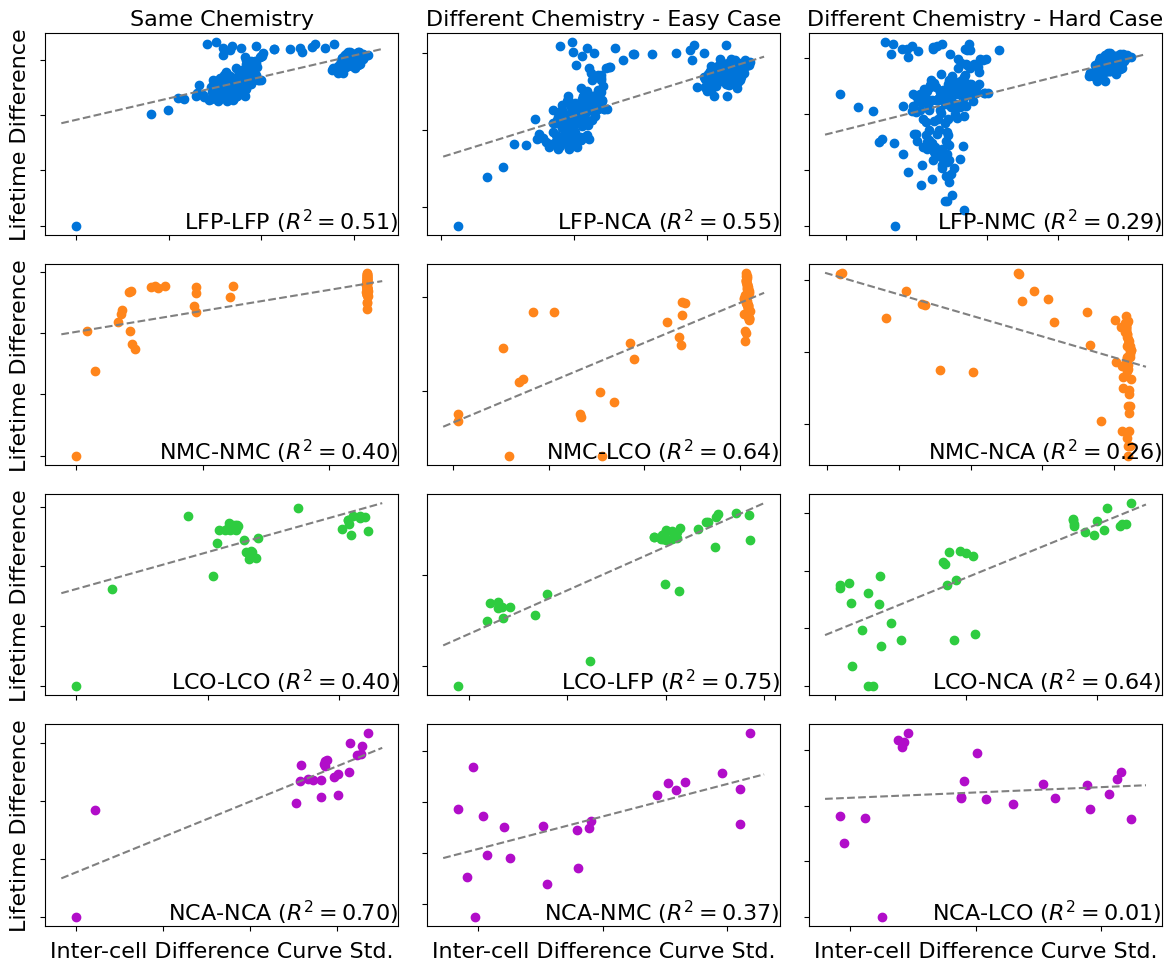

In [28]:
from itertools import product

material_pairs = (
    (('LFP', 'LFP'), ('LFP', 'NCA'), ('LFP', 'NMC')),
    (('NMC', 'NMC'), ('NMC', 'LCO'), ('NMC', 'NCA')),
    (('LCO', 'LCO'), ('LCO', 'LFP'), ('LCO', 'NCA')),
    (('NCA', 'NCA'), ('NCA', 'NMC'), ('NCA', 'LCO')),
)
ref_cell_index = (
    (47, 7, 57),
    (68, 21, 11),
    (1, 266, 12),
    (3, 65, 27)
)
fig, axes = plt.subplots(len(material_map), 3, figsize=(12, 10))

for i, j in product(range(len(axes)), range(len(axes[0]))):
    (mat, ref_mat), ax, ref_indx = material_pairs[i][j], axes[i, j], ref_cell_index[i][j]
    mat_features = [cell.feature for cell in material_map[mat]]
    mat_labels = [cell.label for cell in material_map[mat]]
    ref_cell = material_map[ref_mat][ref_indx]
    x = [get_x(ref_cell.feature, f) for f in mat_features]
    y = [np.log(abs(ref_cell.label - l) + 1) for l in mat_labels]

    _, w, b = least_squares_loss(x, y)

    ax.scatter(x, y, color=palette[i])
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x = np.linspace(*xlim, 1000)
    y = w * x + b
    ax.plot(x, y, color='grey', linestyle='--')

for ax in axes.reshape(-1):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
axes[0, 0].set_title('Same Chemistry', fontsize=16)
axes[0, 1].set_title('Different Chemistry - Easy Case', fontsize=16)
axes[0, 2].set_title('Different Chemistry - Hard Case', fontsize=16)
for i in range(len(axes)):
    axes[i, 0].set_ylabel('Lifetime Difference')
for j in range(len(axes[0])):
    axes[-1, j].set_xlabel('Inter-cell Difference Curve Std.')
plt.tight_layout()

for i, j in product(range(len(axes)), range(len(axes[0]))):
    (mat, ref_mat), ax, ref_indx = material_pairs[i][j], axes[i, j], ref_cell_index[i][j]
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    mat_features = [cell.feature for cell in material_map[mat]]
    mat_labels = [cell.label for cell in material_map[mat]]
    ref_cell = material_map[ref_mat][ref_indx]
    x = np.array([get_x(ref_cell.feature, f) for f in mat_features])
    y = np.array([np.log(abs(ref_cell.label - l) + 1) for l in mat_labels])
    _, w, b = least_squares_loss(x, y)
    y_pred = w * x + b

    score = calculate_r_squared(y, y_pred)

    ax.text(
        xlim[1], ylim[0], f'{mat}-{ref_mat} ($R^2=${score:.2f})',
        horizontalalignment='right',
        verticalalignment='bottom'
    )
fig.savefig(HOME / f'data/detailed_comparison_cross_chemistry.svg',
            bbox_inches='tight', pad_inches=0.1)
plt.show()